# Make plots of active cloud properties

Cloud properties for CanAM have changed noteably.  These plot will summarize them using matplotlib to generate the graphs and compute the averages.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as py
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import xesmf as xe
import os

Function(s) to compute the weighted mean for a DataArray

In [2]:
def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataArray
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average xarray
    """

    if mask is not None:
        wgt=weight*abs(mask)
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    elif weights is not None:
        wgt=weight
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average

Function to compute the weighted mean for DataArrays in a DataSet

In [3]:
def masked_average_ds(xs=None,
                      vars=None,
                      dim=None,
                      weights:xr.DataArray=None,
                      mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataSet
    :param vars: list of variables
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average for all arrays in a DataSet
    """

    i = 0
    for vv in vars:
        data=xs[vv]
        data_mean = masked_average(data,dim=dim,weights=weights,mask=mask)
        # Add mean to dataset that will hold all means
        if i == 0:
            xs_weighted_average = data_mean.to_dataset(name=vv) 
            i=1
        else:
            xs_weighted_average[vv] = data_mean
    return xs_weighted_average

Function to compute the required MODIS climatological data

In [4]:
def get_climo_modis(start_year,
                    end_year,
                    ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_modis")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full.sel(time=slice(year1, year2))

    # Compute the cloud fractions in different manners
    
    # Liquid cloud fraction
    dr_liquid = 100.0*ds_in['Cloud_Retrieval_Fraction_Liquid_Mean'].rename('liquid_cld_amt')

    # Ice cloud fraction
    dr_ice = 100.0*ds_in['Cloud_Retrieval_Fraction_Ice_Mean'].rename('ice_cld_amt')

    # Total cloud fraction
    dr_total = 100.0*ds_in['Cloud_Retrieval_Fraction_Total_Mean'].rename('total_cld_amt')

    # Compute the zonal means
    dz_liquid = dr_liquid.mean('lon',skipna=True).rename('zonal_liquid_cld_amt')
    dz_ice = dr_ice.mean('lon',skipna=True).rename('zonal_ice_cld_amt')
    dz_total = dr_total.mean('lon',skipna=True).rename('zonal_total_cld_amt')

    ds = xr.merge([dr_liquid,dr_ice,dr_total,dz_liquid,dz_ice,dz_total],compat="override")
    ds_out = ds.mean('time')
    
    return ds_out

    

Function to compute the required GOCCP climatological data

In [5]:
def get_climo_goccp(start_year,
                    end_year,
                    ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_goccp")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full.sel(time=slice(year1, year2))
    
    # Rename the altitude dimension to be "alt40" consistent with the 
    # ESM output
    ds_in=ds_in.rename({"altitude":"alt40"})

    # Compute the altitudes
    alt_bnds = ds_in_full['alt_bound']
    alt=(alt_bnds.isel(nv=0)+alt_bnds.isel(nv=1))/2.0
    alt=alt.rename('altitudes').to_dataset()

    # Compute the cloud fraction in different manners
    
    # Zonal mean versus height
    dz_clcalipso = 100.0*ds_in['clcalipso'].mean('lon',skipna=True)
    dz_clcalipsoliq = 100.0*ds_in['clcalipso_liq'].mean('lon')#.rename({'clcalipso_liq':'clcalipsoliq'})
    dz_clcalipsoice = 100.0*ds_in['clcalipso_ice'].mean('lon')#.rename({'clcalipso_ice':'clcalipsoice'})
    dz_clcalipsorpic = 100.0*ds_in['clcalipso_RPIC'].mean('lon')

    # Compute the relative fraction of ice using monthly data
    dz_clcalipsorpic2 = 100.0*ds_in['clcalipso_ice']/(ds_in['clcalipso_liq']+ds_in['clcalipso_ice'])
    dz_clcalipsorpic2 = dz_clcalipsorpic2.mean('lon').rename('clcalipso_RPIC2').to_dataset()

    ds = xr.merge([dz_clcalipso,dz_clcalipsoliq,dz_clcalipsoice,dz_clcalipsorpic,dz_clcalipsorpic2,alt],compat="override")
    
    ds_out = ds.mean('time')
    
    return ds_out

    

Function to compute the required CanESM climatological data

In [6]:
def get_climo_canesm(start_year,
                     end_year,
                     ds_in_full,
                     version="canesm5"):
    
    # Get the model fields and average them
    print("get_climo_canesm")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full.sel(time=slice(year1, year2))
    
    # Compute the cloud fraction in different manners
    
    # Zonal mean versus height
    dz_clcalipso = ds_in['clcalipso'].mean('lon')
    if (version == "canesm5"):
        # CALIPSO
        dz_clcalipsoliq  = ds_in['clcalipsoliq'].mean('lon')
        dz_clcalipsoice  = ds_in['clcalipsoice'].mean('lon')
        dz_clcalipsorpic = 100.0*ds_in['clcalipsoice']/(ds_in['clcalipsoliq']+ds_in['clcalipsoice'])
        dz_clcalipsorpic = dz_clcalipsorpic.mean('lon').rename('clcalipsorpic').to_dataset()
        # MODIS
        clwmodis = ds_in['clwmodis'].rename('liquid_cld_amt')
        climodis = ds_in['climodis'].rename('ice_cld_amt')
        cltmodis = ds_in['cltmodis'].rename('total_cld_amt')
        dz_clwmodis = clwmodis.mean('lon',skipna=True).rename('zonal_liquid_cld_amt')
        dz_climodis = climodis.mean('lon',skipna=True).rename('zonal_ice_cld_amt')
        dz_cltmodis = cltmodis.mean('lon',skipna=True).rename('zonal_total_cld_amt')
        ds = xr.merge([dz_clcalipso,dz_clcalipsoliq,dz_clcalipsoice,dz_clcalipsorpic,clwmodis,climodis,cltmodis,dz_clwmodis,dz_climodis,dz_cltmodis],compat="override")
    else:
        ds = xr.merge([dz_clcalipso],compat="override")

    ds_out = ds.mean('time')

    return ds_out

    

### Compute the zonal and annual means from GOCCP and MODIS products and CanESM, then generate plots with the information.

In [7]:
file_goccp_clcalipso = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/GOCCP/GOCCP-3D-CloudFraction330m-CFMIP2-sat_3.1.2_200606-201912.nc"
file_goccp_clcalipso_phase = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/GOCCP/GOCCP-3D-CloudFraction-Phase330m-CFMIP2-sat_3.1.2_200606-201912.nc"
file_modis = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/MODIS/MCD06COSP-M3-MODIS_061_200207-202107.nc"

file_canam_grid="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/CanAM5_grid.txt"

file_canesm5_clcalipso = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/clcalipso_CFmon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"
file_canesm5_clcalipsoliq = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/clcalipsoliq_Emon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"
file_canesm5_clcalipsoice = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/clcalipsoice_Emon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"
file_canesm5_clwmodis = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/clwmodis_Emon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"
file_canesm5_climodis = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/climodis_Emon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"
file_canesm5_cltmodis = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/cltmodis_Emon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"

file_canesm2_clcalipso = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/clcalipso_cfMon_CanESM2_historical_r1i1p1_197901-200512.nc"

file_areacella="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/areacella_fx_CanAM4_amip_r0i0p0.nc"

start_year=2007
end_year=2014

# Open the datasets
ds1 = xr.open_dataset(file_canesm5_clcalipso)
ds2 = xr.open_dataset(file_canesm5_clcalipsoliq)
ds3 = xr.open_dataset(file_canesm5_clcalipsoice)
ds4 = xr.open_dataset(file_canesm5_clwmodis)
ds5 = xr.open_dataset(file_canesm5_climodis)
ds6 = xr.open_dataset(file_canesm5_cltmodis)
ds_canesm5=xr.merge([ds1,ds2,ds3,ds4,ds5,ds6],compat="override")

ds_canesm2 = xr.open_dataset(file_canesm2_clcalipso)

ds1_goccp = xr.open_dataset(file_goccp_clcalipso)
ds2_goccp = xr.open_dataset(file_goccp_clcalipso_phase)
ds_goccp_clcalipso_in=xr.merge([ds1_goccp,ds2_goccp],compat="override")
ds_areacella = xr.open_dataset(file_areacella)

ds_modis_in = xr.open_dataset(file_modis)

# Define information needed to regrid the observations
lat_target=ds_canesm5['lat'].values
lon_target=ds_canesm5['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], lat_target),
                     'lon': (['lon'], lon_target),
                    }
                   )

regridder_goccp = xe.Regridder(ds_goccp_clcalipso_in['clcalipso'],ds_out,'bilinear')
regridder_modis = xe.Regridder(ds_modis_in['Cloud_Retrieval_Fraction_Liquid_Mean'],ds_out,'bilinear',periodic=True)

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Interpolate fields as needed

In [8]:
ds1 = regridder_goccp(ds_goccp_clcalipso_in['clcalipso']).to_dataset()
ds2 = regridder_goccp(ds_goccp_clcalipso_in['clcalipso_liq']).to_dataset()
ds3 = regridder_goccp(ds_goccp_clcalipso_in['clcalipso_ice']).to_dataset()
ds4 = regridder_goccp(ds_goccp_clcalipso_in['clcalipso_RPIC']).to_dataset()
ds_alt = ds_goccp_clcalipso_in['alt_bound']
ds_goccp_clcalipso=xr.merge([ds1,ds2,ds3,ds4,ds_alt],compat="override")

ds1 = regridder_modis(ds_modis_in['Cloud_Retrieval_Fraction_Liquid_Mean']).to_dataset()
ds2 = regridder_modis(ds_modis_in['Cloud_Retrieval_Fraction_Ice_Mean']).to_dataset()
ds3 = regridder_modis(ds_modis_in['Cloud_Retrieval_Fraction_Total_Mean']).to_dataset()
ds_modis=xr.merge([ds1,ds2,ds3],compat="override")



/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Get the data we need from GOCCP, CanESM2 and CanESM5 for climatologies

In [9]:
ds_goccp_climo = get_climo_goccp(start_year, end_year, ds_goccp_clcalipso)
ds_modis_climo = get_climo_modis(start_year, end_year, ds_modis)
ds_canesm2_climo = get_climo_canesm(start_year, end_year, ds_canesm2,version="canesm2")
ds_canesm5_climo = get_climo_canesm(start_year, end_year, ds_canesm5,version="canesm5")

get_climo_goccp
get_climo_modis
get_climo_canesm
get_climo_canesm


Create a summary plot for near-global zonal cross-section

/tmp/jcl001/195554/ipykernel_200640/4271275721.py:28: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  f1=f_ax1.pcolormesh(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],ds_goccp_climo['clcalipso'],
/tmp/jcl001/195554/ipykernel_200640/4271275721.py:46: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  f2=f_ax2.pcolormesh(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],canesm5_clcalipso_diff,
/tmp/jcl001/195554/ipykernel_200640/4271275721.py:68: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm wh

[Text(0, 0, ''),
 Text(0, 10, ''),
 Text(0, 20, ''),
 Text(0, 30, ''),
 Text(0, 40, ''),
 Text(0, 50, ''),
 Text(0, 60, ''),
 Text(0, 70, ''),
 Text(0, 80, '')]

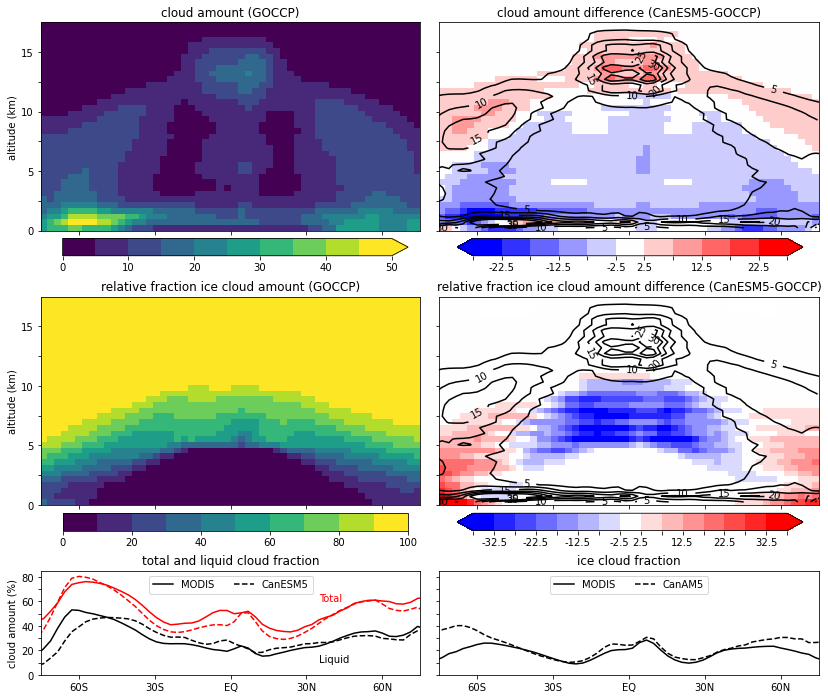

In [11]:
# Compute differences
canesm5_clcalipso_diff = ds_canesm5_climo['clcalipso']-ds_goccp_climo['clcalipso'].reindex_like(ds_canesm5_climo, method='nearest', tolerance=0.01)
canesm2_clcalipso_diff = ds_canesm2_climo['clcalipso']-ds_goccp_climo['clcalipso'].reindex_like(ds_canesm2_climo, method='nearest', tolerance=0.01)
canesm5_clcalipso_rpic_diff = ds_canesm5_climo['clcalipsorpic']-ds_goccp_climo['clcalipso_RPIC2'].reindex_like(ds_canesm5_climo, method='nearest', tolerance=0.01)

# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,12])
widths=[2,2]
heights=[2,2,1]
gs1 = fig.add_gridspec(3,2,width_ratios=widths,
                           height_ratios=heights,left=0.05, right=0.95, wspace=0.05,hspace=0.38)
f_ax1 = fig.add_subplot(gs1[0,0])
f_ax2 = fig.add_subplot(gs1[0,1])
f_ax3 = fig.add_subplot(gs1[1,0])
f_ax4 = fig.add_subplot(gs1[1,1])
f_ax5 = fig.add_subplot(gs1[2,0])
f_ax6 = fig.add_subplot(gs1[2,1])

###################################
# Make the plots
###################################

# Plot the GOCCP total cloud cross-section
cmap = py.get_cmap('viridis')
levels = MaxNLocator(nbins=10).tick_values(0,50)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

f1=f_ax1.pcolormesh(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],ds_goccp_climo['clcalipso'],
                    vmin=0.0,vmax=50.0,cmap=cmap,norm=norm,shading='auto')
f_ax1.set_title("cloud amount (GOCCP)")
f_ax1.set_xlim(-75,75)
f_ax1.set_xticks([-60,-30,0,30,60])
f_ax1.set_xticklabels([])
f_ax1.set_ylim(0,17.5)
f_ax1.set_yticks([0,2.5,5,7.5,10,12.5,15])
f_ax1.set_yticklabels(['0','','5','','10','','15'])
f_ax1.set_ylabel('altitude (km)')
cax1 = py.axes([0.075, 0.61, 0.4, 0.02])
py.colorbar(f1,cax=cax1,orientation='horizontal',extend="max")

cmap = py.get_cmap('bwr')
levels=[-27.5,-22.5,-17.5,-12.5,-7.5,-2.5,2.5,7.5,12.5,17.5,22.5,27.5]
#levels = MaxNLocator(nbins=10).tick_values(-25,25)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

f2=f_ax2.pcolormesh(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],canesm5_clcalipso_diff,
                    vmin=-30.0,vmax=30.0,cmap=cmap,norm=norm,shading='auto')
c_levs=[5,10,15,20,25,30]
f2_2=f_ax2.contour(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],ds_canesm5_climo['clcalipso'],
                   colors='k',levels=c_levs)#,vmin=-45.0,vmax=45.0,cmap='bwr')
f_ax2.set_title("cloud amount difference (CanESM5-GOCCP)")
f_ax2.clabel(f2_2, inline=1, fontsize=10)
f_ax2.set_xlim(-75,75)
f_ax2.set_xticks([-60,-30,0,30,60])
f_ax2.set_xticklabels([])
f_ax2.set_ylim(0,17.5)
f_ax2.set_yticks([0,2.5,5,7.5,10,12.5,15])
f_ax2.set_yticklabels([])

cax2 = py.axes([0.532, 0.61, 0.4, 0.02])
py.colorbar(f2,cax=cax2,orientation='horizontal',extend="both",ticks=levels)
cax2.set_xticklabels(['','-22.5','','-12.5','','-2.5','2.5','','12.5','','22.5',''])

cmap = py.get_cmap('viridis')
levels = MaxNLocator(nbins=10).tick_values(0,100)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

f3=f_ax3.pcolormesh(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],ds_goccp_climo['clcalipso_RPIC2'],
                    vmin=0.0,vmax=100.0,cmap=cmap,norm=norm,shading='auto')
f_ax3.set_title("relative fraction ice cloud amount (GOCCP)")
f_ax3.set_xlim(-75,75)
f_ax3.set_xticks([-60,-30,0,30,60])
f_ax3.set_xticklabels([])
f_ax3.set_ylim(0,17.5)
f_ax3.set_yticks([0,2.5,5,7.5,10,12.5,15])
f_ax3.set_yticklabels(['0','','5','','10','','15'])
f_ax3.set_ylabel('altitude (km)')

cax3 = py.axes([0.075, 0.292, 0.4, 0.02])
py.colorbar(f3,cax=cax3,orientation='horizontal')#,extend="max")

cmap = py.get_cmap('bwr')
levels=np.asarray([-37.5,-32.5,-27.5,-22.5,-17.5,-12.5,-7.5,-2.5,2.5,7.5,12.5,17.5,22.5,27.5,32.5,37.5])
#levels = MaxNLocator(nbins=14).tick_values(-45,45)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

f4=f_ax4.pcolormesh(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],canesm5_clcalipso_rpic_diff,
                    vmin=-42.5,vmax=42.5,cmap=cmap,norm=norm,shading='auto')
c_levs=[5,10,15,20,25,30]
f4_2=f_ax4.contour(ds_goccp_climo['lat'],ds_goccp_climo['altitudes'],ds_canesm5_climo['clcalipso'],
                   colors='k',levels=c_levs)
f_ax4.set_title("relative fraction ice cloud amount difference (CanESM5-GOCCP)")
f_ax4.clabel(f4_2, inline=1, fontsize=10)
f_ax4.set_xlim(-75,75)
f_ax4.set_xticks([-60,-30,0,30,60])
f_ax4.set_xticklabels([])
f_ax4.set_ylim(0,17.5)
f_ax4.set_yticks([0,2.5,5,7.5,10,12.5,15])
f_ax4.set_yticklabels([])

cax4 = py.axes([0.532, 0.292, 0.4, 0.02])
py.colorbar(f4,cax=cax4,orientation='horizontal',extend="both",ticks=levels)
cax4.set_xticklabels(['','-32.5','','-22.5','','-12.5','','-2.5','2.5','','12.5','','22.5','','32.5',''])

f5=f_ax5.plot(ds_modis_climo['lat'],ds_modis_climo['zonal_liquid_cld_amt'],'k-',label="MODIS")
f5_2=f_ax5.plot(ds_canesm5_climo['lat'],ds_canesm5_climo['zonal_liquid_cld_amt'],'k--',label="CanESM5")
f5_3=f_ax5.plot(ds_canesm5_climo['lat'],ds_canesm5_climo['zonal_total_cld_amt'],'r-')
f5_4=f_ax5.plot(ds_canesm5_climo['lat'],ds_modis_climo['zonal_total_cld_amt'],'r--')
#f5_5=f_ax5.plot(ds_canesm5_climo['lat'],p_data,'r--')
f_ax5.set_title("total and liquid cloud fraction")
f_ax5.legend(ncol=2,loc='upper center')
f_ax5.set_xlim(-75,75)
f_ax5.set_xticks([-60,-30,0,30,60])
f_ax5.set_xticklabels(['60S','30S','EQ','30N','60N'])

f_ax5.set_ylim(0,85)
f_ax5.set_yticks([0,10,20,30,40,50,60,70,80])
f_ax5.set_yticklabels(['0','','20','','40','','60','','80'])
f_ax5.set_ylabel('cloud amount (%)')

f_ax5.text(35,60,'Total',color='r')
f_ax5.text(35,10,'Liquid',color='k')

f6=f_ax6.plot(ds_modis_climo['lat'],ds_modis_climo['zonal_ice_cld_amt'],'k-',label="MODIS")
f6_2=f_ax6.plot(ds_canesm5_climo['lat'],ds_canesm5_climo['zonal_ice_cld_amt'],'k--',label="CanAM5")
f_ax6.set_title("ice cloud fraction")
f_ax6.legend(ncol=2,loc='upper center')
f_ax6.set_xlim(-75,75)
f_ax6.set_xticks([-60,-30,0,30,60])
f_ax6.set_xticklabels(['60S','30S','EQ','30N','60N'])
f_ax6.set_ylim(0,85)
f_ax6.set_yticks([0,10,20,30,40,50,60,70,80])
f_ax6.set_yticklabels([])
